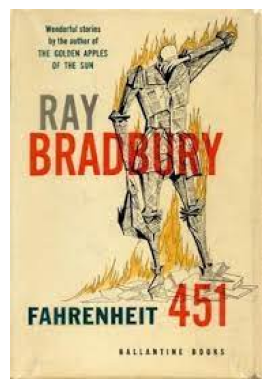

<Figure size 5250x3750 with 0 Axes>

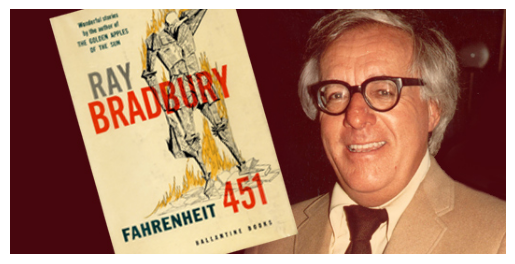

<Figure size 5250x3750 with 0 Axes>

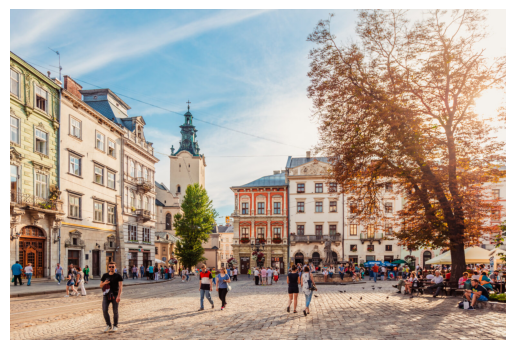

<Figure size 5250x3750 with 0 Axes>

In [72]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def show(img):
    plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(35, 25), dpi=150)
    plt.show()

img1 = cv.imread('photos\\99.jpg')
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
show(img1)

img2 = cv.imread('photos\\999.jpg')
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

show(img2)

img3 = cv.imread('photos\\lviv.jpg')
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)
show(img3)

# detector = cv.xfeatures2d.FastFeatureDetector_create()




In [73]:
def dist(x, y):
  n = len(x)
  assert len(x) == len(y)
  return sum([(x[i] ^ y[i]) for i in range(n)])

def custom_match(img, second):
    detector = cv.xfeatures2d.StarDetector_create()
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

    kp1 = detector.detect(img,None)
    kp2 = detector.detect(second,None)

    kp1, des1 = brief.compute(img1, kp1)
    kp2, des2= brief.compute(img2, kp2)
    matches = []
    for i, k1 in enumerate(des1):
      for j, k2 in enumerate(des2):
        matches.append(cv.DMatch(_distance=dist(k1,k2), _imgIdx=0, _queryIdx=i, _trainIdx=j))

    matches = sorted(matches, key = lambda x : x.distance)

    img3 = cv.drawMatches(img, kp1, second, kp2, matches[:15], None,
                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    show(img3)


In [74]:
def bf_match(img,second):
    detector = cv.xfeatures2d.StarDetector_create()
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

    kp1 = detector.detect(img,None)
    kp2 = detector.detect(second,None)

    kp1, des1 = brief.compute(img, kp1)
    kp2, des2 = brief.compute(second, kp2)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1,des2)

    matches = sorted(matches, key = lambda x:x.distance)

    img4 = cv.drawMatches(img,kp1,second,kp2,matches[:15],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    show(img4)

In [101]:
def affine(img):
    img = cv.warpAffine(img, np.array([[1, -0.3, 0], [0, 1, 0]]), img1.shape[:2][::-1])
    return img

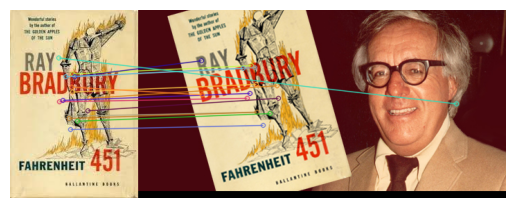

<Figure size 5250x3750 with 0 Axes>

In [76]:
custom_match(img1,img2)

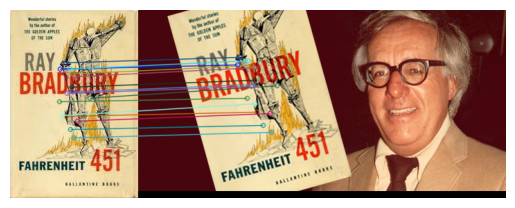

<Figure size 5250x3750 with 0 Axes>

In [77]:
bf_match(img1,img2)

In [102]:
img4 = affine(img3)

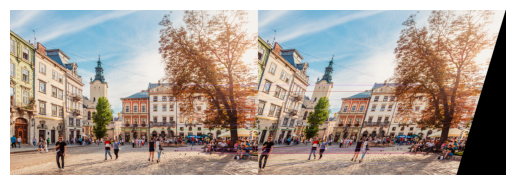

<Figure size 5250x3750 with 0 Axes>

In [103]:
bf_match(img3, img4)

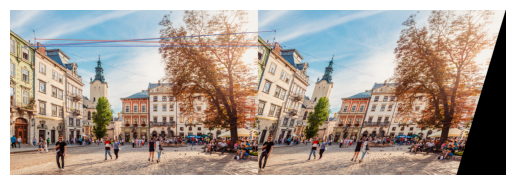

<Figure size 5250x3750 with 0 Axes>

In [104]:
custom_match(img3, img4)

In [128]:
rot_1 = cv.rotate(img3, cv.ROTATE_180)

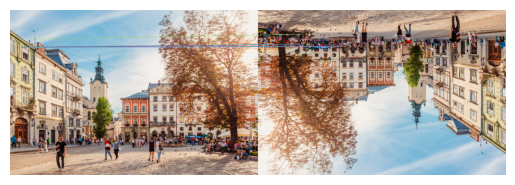

<Figure size 5250x3750 with 0 Axes>

In [82]:
custom_match(img3, rot_1)

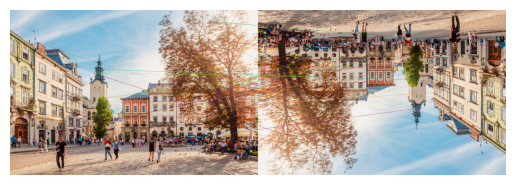

<Figure size 5250x3750 with 0 Axes>

In [83]:
bf_match(img3, rot_1)

In [84]:
# rot_2 = cv.rotate(img2, cv.ROTATE_180)

In [105]:
import random

def get_point(points, p1):
    return np.array([p1[point.queryIdx].pt for point in points]).reshape(-1,1,2)

In [134]:


def ransac(matches, kp1, kp2, iterations=1000, threshold=10):
    i = 0
    target = []
    while i <  iterations:
        random_points = random.sample(matches, 4)
        first_points = get_point(random_points, kp1)
        scnd_points = get_point(random_points, kp2)
        H, _ = cv.findHomography(first_points, scnd_points, cv.RANSAC, threshold)

        inliers = []
        for sample in matches:
            src_pt = np.array(kp1[sample.queryIdx].pt).reshape(-1,1,2)
            dst_pt = np.array(kp2[sample.trainIdx].pt).reshape(-1,1,2)
            transformed_pt = cv.perspectiveTransform(src_pt, H)
            dist = np.linalg.norm(dst_pt - transformed_pt)
            if dist < threshold:
                inliers.append(sample)

        if len(inliers) > len(target):
            target = inliers
        i+=1

    first_points = get_point(target, kp1)
    scnd_points = get_point(target, kp2)
    H, _ = cv.findHomography(first_points, scnd_points, 0)

    return H, target

In [130]:
def brief_ransac_matcher(img, second):
    detector = cv.xfeatures2d.StarDetector_create()
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

    kp1 = detector.detect(img,None)
    kp2 = detector.detect(second,None)

    kp1, des1 = brief.compute(img, kp1)
    kp2, des2 = brief.compute(second, kp2)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    H, inliers = ransac(matches, kp1, kp2)

    с = cv.drawMatches(img, kp1, second, kp2, inliers[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show(с)

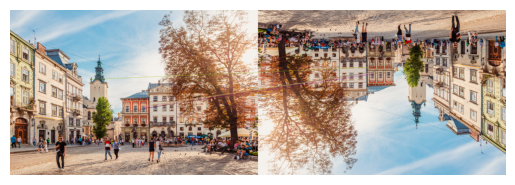

<Figure size 5250x3750 with 0 Axes>

In [131]:
brief_ransac_matcher(img3, rot_1)

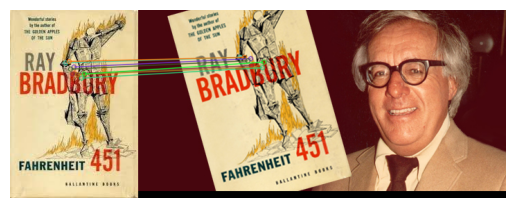

<Figure size 5250x3750 with 0 Axes>

In [133]:
brief_ransac_matcher(img1, img2)